# Predicting SST

In this article, we use an autoregressive model to forecast SST. This is similar to the autoregressive models used for LLMs, except here we predict many real-valued variables at each timestep, so it is more difficult.

The data is downloaded from NOAA in `03_prepare_data.ipynb`. You can download the preprocessed data from [this link](https://drive.google.com/drive/folders/1COWlUBZANGQFVO43N4X53nW3wyZdJqGW?usp=sharing).

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import cartopy.crs as ccrs
import cmocean.cm as cmo

# Define Dataset

In [91]:
netcdf_file = xr.open_dataset("data/ersst_pacific_anom_1854_2025.nc")
ssta = (
    netcdf_file.ssta
    .drop_vars("month")
    #.expand_dims("channel")
    #.transpose("time", "channel", "lat", "lon")
    .fillna(0)
)


In [86]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class AutoregressiveVideoDataset(Dataset):
    def __init__(self, video_da: xr.DataArray, seq_len: int):
        """
        Initializes the AutoregressiveVideoDataset.

        Args:
            video_da (xr.DataArray): The input video DataArray with dimensions ('time', 'height', 'width').
            seq_len (int): The length of the input sequence for the autoregressive model.
                           The target will be the frame immediately following the input sequence.
        """
        if 'time' not in video_da.dims:
            raise ValueError("The input DataArray must have a 'time' dimension.")
        if video_da.ndim != 3:
            raise ValueError("The input DataArray must have 3 dimensions: ('time', 'height', 'width').")

        self.video_da = video_da
        self.seq_len = seq_len

        # Slice the DataArray to start from a point where a full sequence + target is available
        video_da = video_da.isel(time=slice(0, -seq_len)) # Ensure we have enough frames for at least one sequence
        
        # Create rolling windows along the time dimension
        self.rolling_windows = video_da.rolling(time=seq_len + 1)#.construct("lead").fillna(0)

        # Convert the valid rolling windows to a stacked array
        self.sequences = self.rolling_windows.construct(window_dim='seq_index')

        # Fill nans with zero
        self.sequences = self.sequences.fillna(0)
        
        # Transpose the dimensions to move 'seq_index' to the second position (dimension 1)
        self.sequences = self.sequences.transpose('time', 'seq_index', 'lat', 'lon')

    def __len__(self):
        """
        Returns the total number of autoregressive sequences.
        """
        return self.sequences.time.size

    def __getitem__(self, idx: int):
        """
        Returns a single autoregressive sequence and its target frame.

        Args:
            idx (int): The index of the sequence to retrieve.

        Returns:
            tuple: A tuple containing two PyTorch tensors:
                   - input_sequence (torch.Tensor): A tensor of shape (seq_len, height, width)
                   - target_frame (torch.Tensor): A tensor of shape (height, width)
        """
        sequence = self.sequences.isel(time=idx).values  # Shape: (seq_len + 1, height, width)

        input_sequence = torch.tensor(sequence[:-1], dtype=torch.float32)
        target_frame = torch.tensor(sequence[-1], dtype=torch.float32)

        return input_sequence, target_frame

def create_autoregressive_dataset(video_da: xr.DataArray, seq_len: int):
    """
    Creates a PyTorch Dataset for autoregressive learning from an xarray video.

    Args:
        video_da (xr.DataArray): The input video DataArray with dimensions ('time', 'height', 'width').
        seq_len (int): The length of the input sequence for the autoregressive model.
                       The target will be the frame immediately following the input sequence.

    Returns:
        AutoregressiveVideoDataset: A PyTorch Dataset object.
    """
    return AutoregressiveVideoDataset(video_da, seq_len)



In [87]:
autoregressive_dataset = create_autoregressive_dataset(ssta, seq_len=2)

# The data is batched for training.
batch_size = 4
dataloader = DataLoader(autoregressive_dataset, batch_size=batch_size, shuffle=False)

for batch_idx, (inputs, targets) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("  Input batch shape:", inputs.shape)
    print("  Target batch shape:", targets.shape)
    if batch_idx == 0:
        break



Batch 1:
  Input batch shape: torch.Size([4, 2, 41, 86])
  Target batch shape: torch.Size([4, 41, 86])


# Define Model

In [100]:
# Define a simple autoregressive model
class AutoregressiveVideoModel(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(AutoregressiveVideoModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (batch_size, input_channels, height, width)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x  # (batch_size, output_channels, height, width)


# Train the model
def train_model(model, train_loader, optimizer, loss_fn, epochs=10):
    """
    Trains the autoregressive video model.

    Args:
        model (nn.Module): The autoregressive model.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): The optimizer.
        loss_fn (nn.Module): The loss function.
        epochs (int): The number of epochs to train. Defaults to 10.
    """
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Loss: {total_loss / len(train_loader)}")

#  Generate a future frame given a sequence of past frames
def generate_next_frame(model, input_frame):
    """
    Generates the next frame given a sequence of past frames.

    Args:
        model (nn.Module): Trained autoregressive model.
        input_frame (torch.Tensor): Tensor of shape (1, sequence_length, height, width).

    Returns:
        torch.Tensor: The predicted next frame of shape (1, channels, height, width).
    """
    model.eval()
    with torch.no_grad():
        # Use the last frame in the input sequence as the input to the model
        next_frame = model(input_frame)
        return next_frame.unsqueeze(0) # Add the batch dimension back



# Training

In [146]:
# Hyperparameters
channels, height, width = inputs.shape[1:5]
output_channels = 1
hidden_channels = 16
epochs = 5

# Initialize model, loss function, and optimizer
model = AutoregressiveVideoModel(channels, hidden_channels, output_channels)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, dataloader, optimizer, loss_fn, epochs)


Epoch: 1, Loss: 0.19455740597925297
Epoch: 2, Loss: 0.18571086177160304
Epoch: 3, Loss: 0.18450124796610398
Epoch: 4, Loss: 0.1839694574417307
Epoch: 5, Loss: 0.18364493411164803


In [189]:
# Generate a prediction.
# Example: Use the first 2 frames from the first video in the batch to predict the 3rd frame
frame = autoregressive_dataset.sequences[:1, :-1, :, :] # (1, 2, 41, 86)
input_tensor = torch.tensor(frame.to_numpy(), dtype=torch.float32)
next_frame = generate_next_frame(model, input_tensor)
#next_frame = model(input_tensor).detach().numpy()
print("Predicted next frame shape:", next_frame.shape)  # Should be (1, 1, 41, 86)
next_frame = next_frame.squeeze()

Predicted next frame shape: torch.Size([1, 1, 1, 41, 86])


# Plot Prediction

Plot the prediction. 

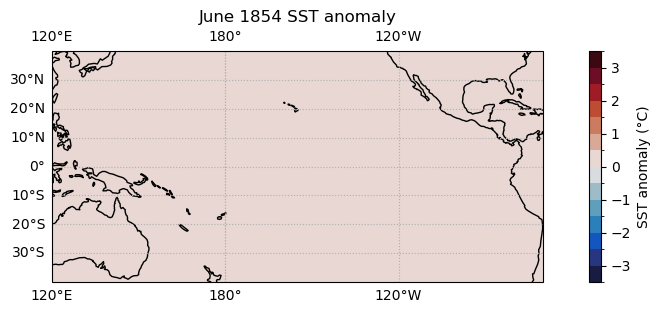

In [188]:
# Plot example
fig, ax = plt.subplots(
    figsize=(12, 3), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))
)

# Create a new xarray DataArray with the new data and existing coordinates
new_da = xr.DataArray(
    next_frame[0, 0, 0,...], # Remove first two dims.
    coords={'lat': ssta.lat, 'lon': ssta.lon},
    dims=['lat', 'lon'],
    #dims=ssta.dims[1,2],
    name='predicted sst',  # You can give it a new name
    attrs={'description': 'This is new data'} # You can also add new attributes
)

new_da.sel().squeeze().plot.contourf(
    ax=ax,
    cmap=cmo.balance,
    levels=[-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    transform=ccrs.PlateCarree(),
    cbar_kwargs=dict(label="SST anomaly (°C)"),
)
ax.coastlines()
# ax.set_extent([120, 290, -40, 40], crs=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linestyle=":")
gl.xlabels_top = False
gl.ylabels_right = False

ax.set_title("June 1854 SST anomaly")
fig.savefig("ersst_anom.png", bbox_inches="tight", dpi=300)